# Nesse código há a atenuação do som em determinados picos de audio pre cadastrados, próximo avanço é detectart automaticamente os picos e diminuir o volume.     

In [1]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, butter, filtfilt
from scipy.fft import fft, ifft

In [2]:
def lowpass_filter(data, cutoff_freq, sample_rate, filter_order=5):
    nyquist_rate = 0.5 * sample_rate
    normalized_cutoff = cutoff_freq/ nyquist_rate
    b_coeficiente,a_coeficiente = butter(filter_order, normalized_cutoff, btype='low',analog=False)
    filtered_signal = filtfilt(b_coeficiente,a_coeficiente,data)
    return filtered_signal

def normalize_audio_int32(data):
    max_val = np.max(np.abs(data))
    normalized_data = data / max_val * 2147483647
    return normalized_data.astype(np.int32)

C:\Users\Windows\AppData\Local\Temp\ipykernel_3236\824918102.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio_signal = wavfile.read('teste.wav')


Sample Rate: 96000
Audio Signal Shape: (1681979, 2)
Max Value (Original Signal): 0.9989989995956421
Min Value (Original Signal): -0.9989989995956421


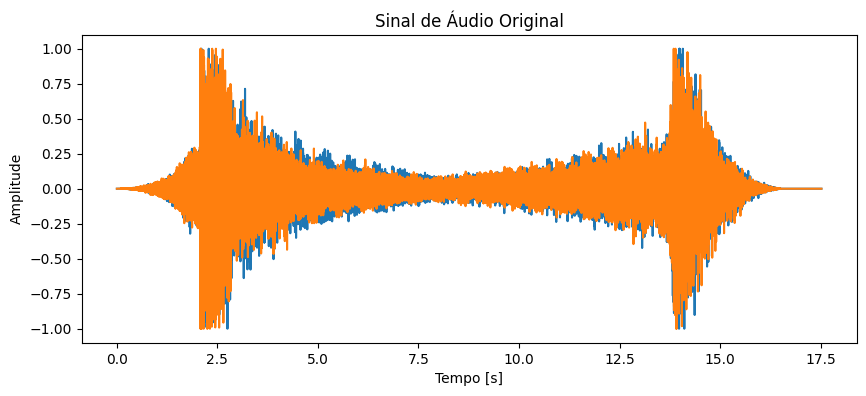

Filtered Signal Shape: (1681979,)
Max Value (Filtered Signal): 0.9834734201431274
Min Value (Filtered Signal): -0.9377206563949585


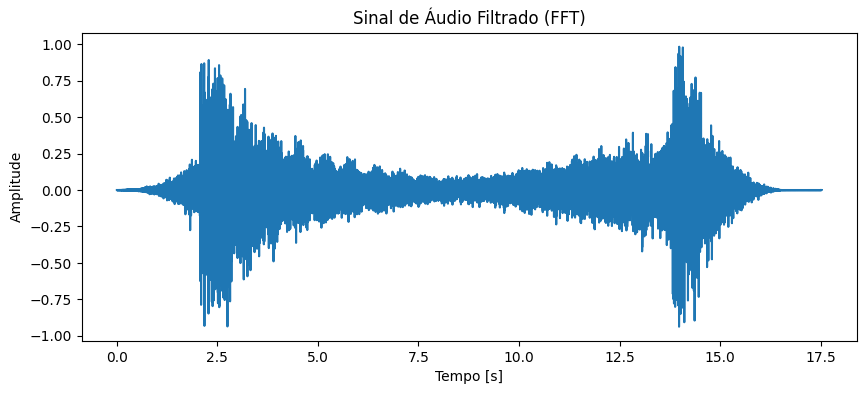

Max Value (Normalized Signal): 2147483647
Min Value (Normalized Signal): -2147483647


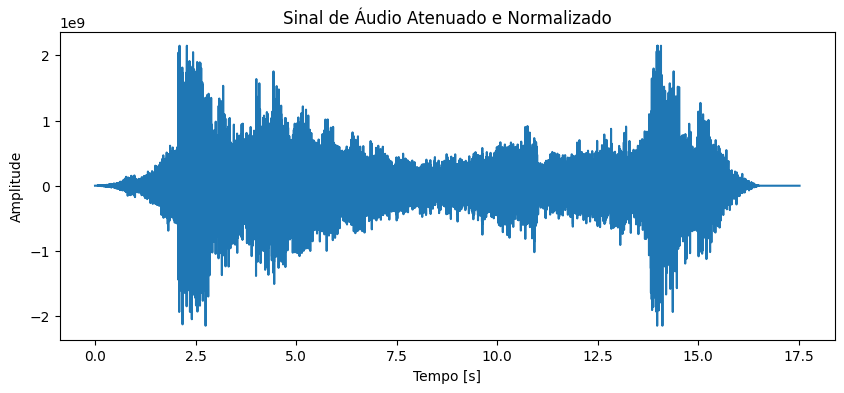

Sinal filtrado, atenuado e normalizado salvo como saida2.wav


In [6]:
# Ler o arquivo de áudio
sample_rate, audio_signal = wavfile.read('teste.wav')

print(f"Sample Rate: {sample_rate}")
print(f"Audio Signal Shape: {audio_signal.shape}")
print(f"Max Value (Original Signal): {np.max(audio_signal)}")
print(f"Min Value (Original Signal): {np.min(audio_signal)}")

# Plotar o sinal original no domínio do tempo
plt.figure(figsize=(10, 4))
time_axis = np.linspace(0, len(audio_signal) / sample_rate, len(audio_signal))
plt.plot(time_axis, audio_signal)
plt.title('Sinal de Áudio Original')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude')
plt.show()

# Se o sinal tiver mais de um canal, selecionar apenas o primeiro canal
if len(audio_signal.shape) > 1:
    audio_signal = audio_signal[:, 0]


# Aplicar FFT ao sinal de áudio
fft_signal = fft(audio_signal)
frequencies = np.fft.fftfreq(len(audio_signal), 1 / sample_rate)

# Filtrar frequências acima de 1000 Hz
cutoff_frequency = 1000
fft_signal[np.abs(frequencies) > cutoff_frequency] = 0

# Transformar de volta ao domínio do tempo
filtered_signal = np.real(ifft(fft_signal))

print(f"Filtered Signal Shape: {filtered_signal.shape}")
print(f"Max Value (Filtered Signal): {np.max(filtered_signal)}")
print(f"Min Value (Filtered Signal): {np.min(filtered_signal)}")

# Plotar o sinal filtrado no domínio do tempo
plt.figure(figsize=(10, 4))
plt.plot(time_axis, filtered_signal)
plt.title('Sinal de Áudio Filtrado (FFT)')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude')
plt.show()

# Atenuar segmentos específicos do sinal
segments_to_attenuate = [(1, 4), (11, 15)]
attenuation_factor = 0.5

attenuated_signal = audio_signal.copy()
for start_time, end_time in segments_to_attenuate:
    start_sample = int(start_time * sample_rate)
    end_sample = int(end_time * sample_rate)
    attenuated_signal[start_sample:end_sample] *= attenuation_factor

# Normalizar o sinal atenuado
normalized_filtered_signal = normalize_audio_int32(attenuated_signal)
#scaled_normalized_signal = normalized_signal * factor
print(f"Max Value (Normalized Signal): {np.max(normalized_filtered_signal)}")
print(f"Min Value (Normalized Signal): {np.min(normalized_filtered_signal)}")

# Plotar o sinal filtrado, atenuado e normalizado
plt.figure(figsize=(10, 4))
plt.plot(time_axis, normalized_filtered_signal)
plt.title('Sinal de Áudio Atenuado e Normalizado')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude')
plt.show()

# Salvar o sinal processado como um novo arquivo WAV
output_filename = 'saida2.wav'
wavfile.write(output_filename, sample_rate, normalized_filtered_signal)

print(f"Sinal filtrado, atenuado e normalizado salvo como {output_filename}")

In [4]:
max_val = np.max(np.abs(audio_signal))
normalized_signal = audio_signal / max_val
print(np.min(audio_signal))

-0.998999


In [5]:
amplitudes = np.around(normalized_signal, decimals=3)
tempos_3dec = np.around(time_axis, decimals=3)


# Teste 1

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

valores_normalizados = np.array(amplitudes)
tempos = np.array(tempos_3dec)


train_size = int(0.8 * len(valores_normalizados))
valores_train, valores_test = valores_normalizados[:train_size],valores_normalizados[train_size:]
tempos_train,tempo_teste = tempos[:train_size],tempos[train_size:]

model1 = models.Sequential()
model1.add(layers.Dense(32,activation='relu',input_shape=(1,)))
model1.add(layers.Dense(1))

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

model1.fit(valores_train,tempos_train,epochs=400, verbose=1,batch_size=32)

loss = model1.evaluate(valores_test,tempo_teste)
print(f'Perda no teste: {loss}')

valores_novos = np.array([0.15,0.85,0.55])
tempos_previstos = model1.predict(valores_novos)
print(f'Tempos previstos: {tempos_previstos}')

c:\Users\Windows\Documents\TCC\Aplicação\TCC\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/400
42050/42050 ━━━━━━━━━━━━━━━━━━━━ 54s 1ms/step - loss: 17.6006
Epoch 2/400
42050/42050 ━━━━━━━━━━━━━━━━━━━━ 63s 2ms/step - loss: 16.2474
Epoch 3/400
42050/42050 ━━━━━━━━━━━━━━━━━━━━ 72s 2ms/step - loss: 16.2172
Epoch 4/400
42050/42050 ━━━━━━━━━━━━━━━━━━━━ 77s 2ms/step - loss: 16.2336
Epoch 5/400
42050/42050 ━━━━━━━━━━━━━━━━━━━━ 53s 1ms/step - loss: 16.2127
Epoch 6/400
42050/42050 ━━━━━━━━━━━━━━━━━━━━ 82s 1ms/step - loss: 16.1914
Epoch 7/400
42050/42050 ━━━━━━━━━━━━━━━━━━━━ 53s 1ms/step - loss: 16.1754
Epoch 8/400
42050/42050 ━━━━━━━━━━━━━━━━━━━━ 53s 1ms/step - loss: 15.6991
Epoch 9/400
42050/42050 ━━━━━━━━━━━━━━━━━━━━ 55s 1ms/step - loss: 15.4108
Epoch 10/400
42050/42050 ━━━━━━━━━━━━━━━━━━━━ 53s 1ms/step - loss: 15.2930
Epoch 11/400
42050/42050 ━━━━━━━━━━━━━━━━━━━━ 55s 1ms/step - loss: 15.2040
Epoch 12/400
42050/42050 ━━━━━━━━━━━━━━━━━━━━ 55s 1ms/step - loss: 15.1577
Epoch 13/400
42050/42050 ━━━━━━━━━━━━━━━━━━━━ 56s 1ms/step - loss: 15.0870
Epoch 14/400
42050/42050 ━━━━━━━━━

In [8]:
teste = np.array([0.705,0.757,0.805,0.857,0.905,0.957,0.985])
tempo_teste01 = model1.predict(teste)
print(f'Possiveis tempos para os valores \n Valores: {teste}\n Tempos: {tempo_teste01}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Possiveis tempos para os valores 
 Valores: [0.705 0.757 0.805 0.857 0.905 0.957 0.985]
 Tempos: [[ 5.787528 ]
 [ 5.9072485]
 [ 7.205802 ]
 [ 9.001807 ]
 [10.659705 ]
 [12.455726 ]
 [13.422812 ]]


In [16]:
print(np.max(tempo_teste01))

9.20196


# teste 2 IA

In [6]:
threshold = np.mean(audio_signal) + 2 * np.std(audio_signal)
labels = (audio_signal > threshold).astype(int)
print(threshold)
print(labels)

0.25100599073164176
[0 0 0 ... 0 0 0]


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

windows_size = 100
overlap = 50
x =[]
y = []

for i in range(0,len(normalized_signal) - windows_size +1, windows_size - overlap):
    x.append(normalized_signal[i:i + windows_size])
    y.append(labels[i + windows_size//2])

X = np.array(x)
Y = np.array(y)

X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

dataset = TensorDataset(X_tensor,Y_tensor)
dataLoader = DataLoader(dataset,batch_size=32, shuffle=True)

class PeakDetector(nn.Module):
    def __init__(self):
        super(PeakDetector, self).__init__()
        self.fc1 = nn.Linear(windows_size, 100) # teste com 5 fc e com 200 de de inicio deu errado
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50,10)
        self.fc4 = nn.Linear(10,1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x
    
model = PeakDetector()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # teste com 0,0001 deu errado

num_epochs = 400
for epoch in range(num_epochs):
    for inputs, targets in dataLoader:
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Eposh {epoch+1}/{num_epochs}, loss: {loss.item()}')

with torch.no_grad():
    test_signal = normalized_signal[:windows_size]
    teste_tensor = torch.tensor(test_signal, dtype=torch.float32).unsqueeze(0)
    predicted_peak = model(teste_tensor).item()

    print(f'Probabilidade de pico na janela de teste: {predicted_peak}')

Eposh 1/400, loss: 0.019451716914772987
Eposh 2/400, loss: 6.875382041471312e-06
Eposh 3/400, loss: 5.144646274857223e-05
Eposh 4/400, loss: 2.505779775674455e-06
Eposh 5/400, loss: 5.969465291855158e-06
Eposh 6/400, loss: 6.867979607250163e-08
Eposh 7/400, loss: 1.8440849771650392e-06
Eposh 8/400, loss: 6.366462912410498e-08
Eposh 9/400, loss: 5.931863000796511e-09
Eposh 10/400, loss: 1.76430130522931e-05
Eposh 11/400, loss: 0.004327141214162111
Eposh 12/400, loss: 5.329487976268865e-06
Eposh 13/400, loss: 0.0023402711376547813
Eposh 14/400, loss: 8.71237393340607e-09
Eposh 15/400, loss: 5.469944497349388e-09
Eposh 16/400, loss: 1.9301317024655873e-06
Eposh 17/400, loss: 2.617506424940075e-06
Eposh 18/400, loss: 5.8268145863848986e-09
Eposh 19/400, loss: 1.3103234053346569e-09
Eposh 20/400, loss: 7.564262105574926e-09
Eposh 21/400, loss: 4.6383852350118104e-06
Eposh 22/400, loss: 4.085049658897333e-05
Eposh 23/400, loss: 4.14556979239436e-13
Eposh 24/400, loss: 0.08798006922006607
Epo

c:\Users\Windows\Documents\TCC\Aplicação\TCC\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


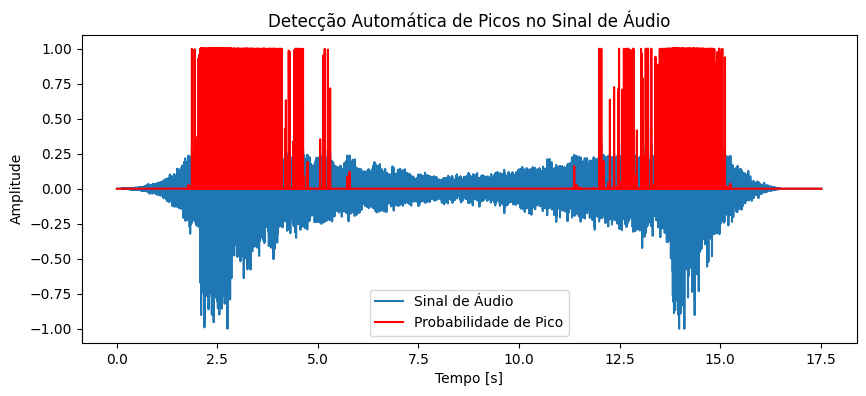

In [16]:
# janela 100 epoch 100 otimização 01
detected_peaks = []
with torch.no_grad():
    for i in range(len(normalized_signal) - windows_size):
        window = normalized_signal[i:i + windows_size]
        window_tensor = torch.tensor(window, dtype=torch.float32).unsqueeze(0)
        peak_prob = model(window_tensor).item()
        detected_peaks.append(peak_prob)

# Plotar os picos detectados
detected_peaks = np.array(detected_peaks)
plt.figure(figsize=(10, 4))
plt.plot(time_axis[:len(detected_peaks)], normalized_signal[:len(detected_peaks)], label='Sinal de Áudio')
plt.plot(time_axis[:len(detected_peaks)], detected_peaks, color='red', label='Probabilidade de Pico')
plt.title('Detecção Automática de Picos no Sinal de Áudio')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

c:\Users\Windows\Documents\TCC\Aplicação\TCC\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


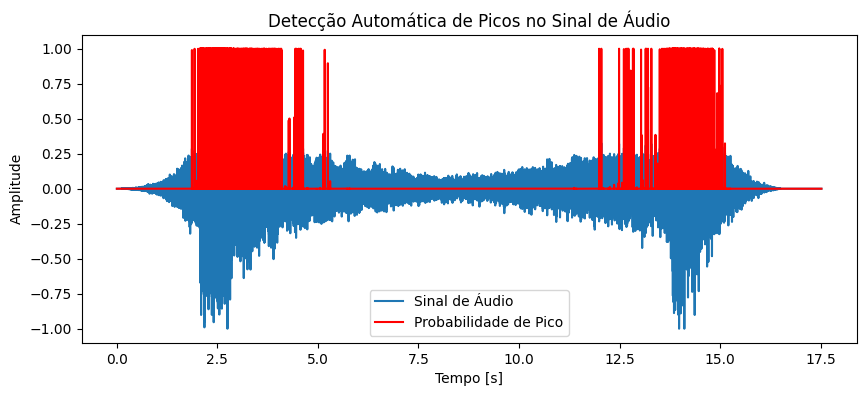

In [8]:
# janela 100 epoch 100 otimização 02
detected_peaks = []
with torch.no_grad():
    for i in range(len(normalized_signal) - windows_size):
        window = normalized_signal[i:i + windows_size]
        window_tensor = torch.tensor(window, dtype=torch.float32).unsqueeze(0)
        peak_prob = model(window_tensor).item()
        detected_peaks.append(peak_prob)

# Plotar os picos detectados
detected_peaks = np.array(detected_peaks)
plt.figure(figsize=(10, 4))
plt.plot(time_axis[:len(detected_peaks)], normalized_signal[:len(detected_peaks)], label='Sinal de Áudio')
plt.plot(time_axis[:len(detected_peaks)], detected_peaks, color='red', label='Probabilidade de Pico')
plt.title('Detecção Automática de Picos no Sinal de Áudio')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

c:\Users\Windows\Documents\TCC\Aplicação\TCC\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


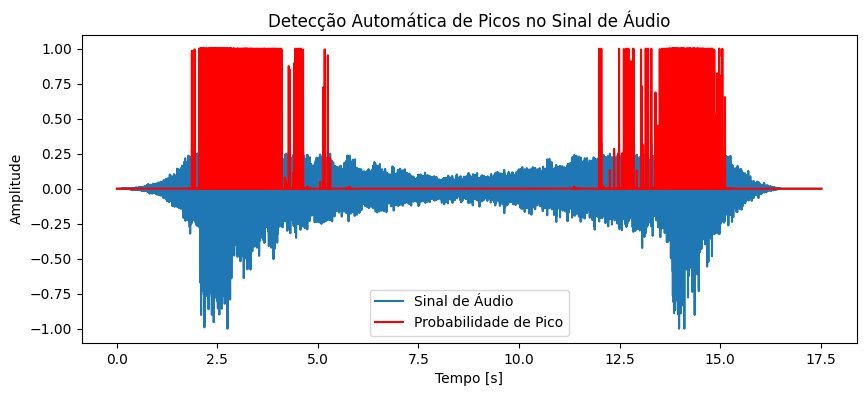

In [10]:
# janela 100 epoch 100 otimização 03
detected_peaks = []
with torch.no_grad():
    for i in range(len(normalized_signal) - windows_size):
        window = normalized_signal[i:i + windows_size]
        window_tensor = torch.tensor(window, dtype=torch.float32).unsqueeze(0)
        peak_prob = model(window_tensor).item()
        detected_peaks.append(peak_prob)

# Plotar os picos detectados
detected_peaks = np.array(detected_peaks)
plt.figure(figsize=(10, 4))
plt.plot(time_axis[:len(detected_peaks)], normalized_signal[:len(detected_peaks)], label='Sinal de Áudio')
plt.plot(time_axis[:len(detected_peaks)], detected_peaks, color='red', label='Probabilidade de Pico')
plt.title('Detecção Automática de Picos no Sinal de Áudio')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

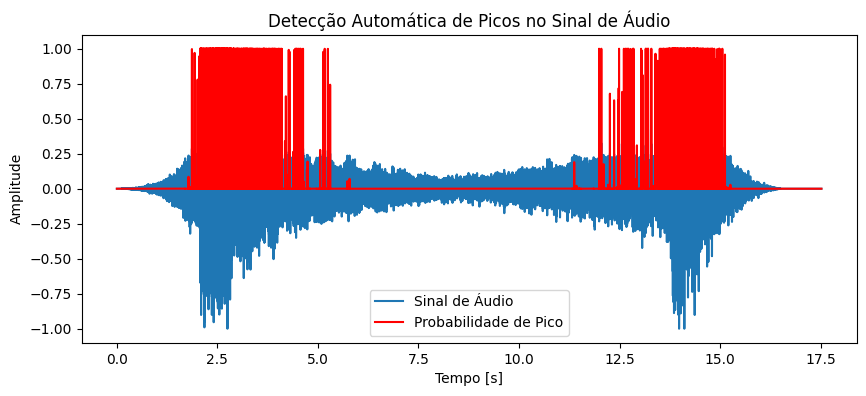

In [12]:
# janela 100 epoch 100 otimização 04
detected_peaks = []
with torch.no_grad():
    for i in range(len(normalized_signal) - windows_size):
        window = normalized_signal[i:i + windows_size]
        window_tensor = torch.tensor(window, dtype=torch.float32).unsqueeze(0)
        peak_prob = model(window_tensor).item()
        detected_peaks.append(peak_prob)

# Plotar os picos detectados
detected_peaks = np.array(detected_peaks)
plt.figure(figsize=(10, 4))
plt.plot(time_axis[:len(detected_peaks)], normalized_signal[:len(detected_peaks)], label='Sinal de Áudio')
plt.plot(time_axis[:len(detected_peaks)], detected_peaks, color='red', label='Probabilidade de Pico')
plt.title('Detecção Automática de Picos no Sinal de Áudio')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

c:\Users\Windows\Documents\TCC\Aplicação\TCC\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


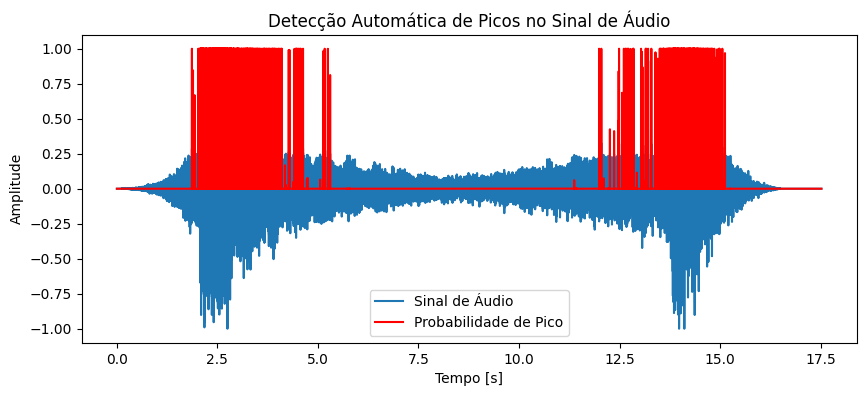

In [8]:
# janela 100 epoch 400 otimização 03
detected_peaks = []
with torch.no_grad():
    for i in range(len(normalized_signal) - windows_size):
        window = normalized_signal[i:i + windows_size]
        window_tensor = torch.tensor(window, dtype=torch.float32).unsqueeze(0)
        peak_prob = model(window_tensor).item()
        detected_peaks.append(peak_prob)

# Plotar os picos detectados
detected_peaks = np.array(detected_peaks)
plt.figure(figsize=(10, 4))
plt.plot(time_axis[:len(detected_peaks)], normalized_signal[:len(detected_peaks)], label='Sinal de Áudio')
plt.plot(time_axis[:len(detected_peaks)], detected_peaks, color='red', label='Probabilidade de Pico')
plt.title('Detecção Automática de Picos no Sinal de Áudio')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

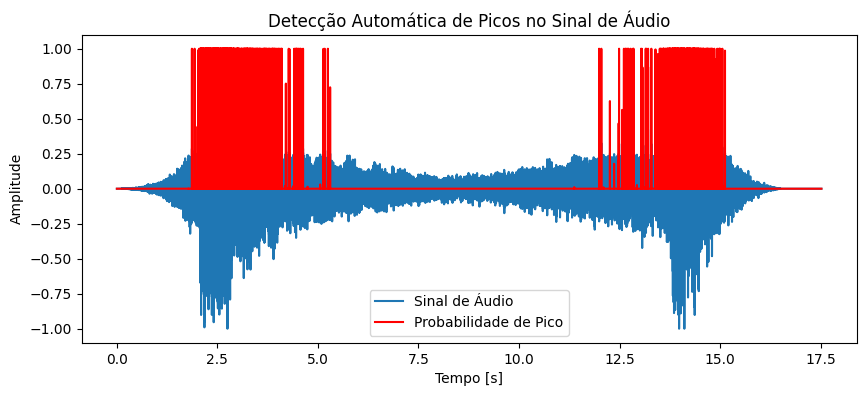

In [12]:
# janela 150 epoch 100
detected_peaks = []
with torch.no_grad():
    for i in range(len(normalized_signal) - windows_size):
        window = normalized_signal[i:i + windows_size]
        window_tensor = torch.tensor(window, dtype=torch.float32).unsqueeze(0)
        peak_prob = model(window_tensor).item()
        detected_peaks.append(peak_prob)

# Plotar os picos detectados
detected_peaks = np.array(detected_peaks)
plt.figure(figsize=(10, 4))
plt.plot(time_axis[:len(detected_peaks)], normalized_signal[:len(detected_peaks)], label='Sinal de Áudio')
plt.plot(time_axis[:len(detected_peaks)], detected_peaks, color='red', label='Probabilidade de Pico')
plt.title('Detecção Automática de Picos no Sinal de Áudio')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

c:\Users\Windows\Documents\TCC\Aplicação\TCC\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


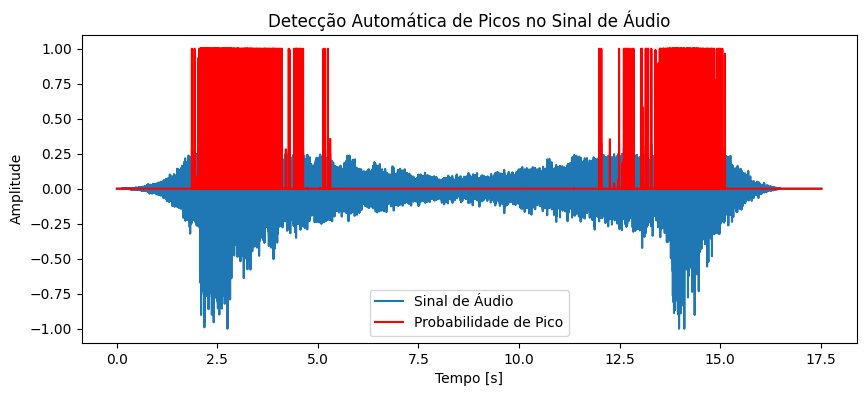

In [8]:
# janela 50 epoch 100
detected_peaks = []
with torch.no_grad():
    for i in range(len(normalized_signal) - windows_size):
        window = normalized_signal[i:i + windows_size]
        window_tensor = torch.tensor(window, dtype=torch.float32).unsqueeze(0)
        peak_prob = model(window_tensor).item()
        detected_peaks.append(peak_prob)

# Plotar os picos detectados
detected_peaks = np.array(detected_peaks)
plt.figure(figsize=(10, 4))
plt.plot(time_axis[:len(detected_peaks)], normalized_signal[:len(detected_peaks)], label='Sinal de Áudio')
plt.plot(time_axis[:len(detected_peaks)], detected_peaks, color='red', label='Probabilidade de Pico')
plt.title('Detecção Automática de Picos no Sinal de Áudio')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

c:\Users\Windows\Documents\TCC\Aplicação\TCC\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


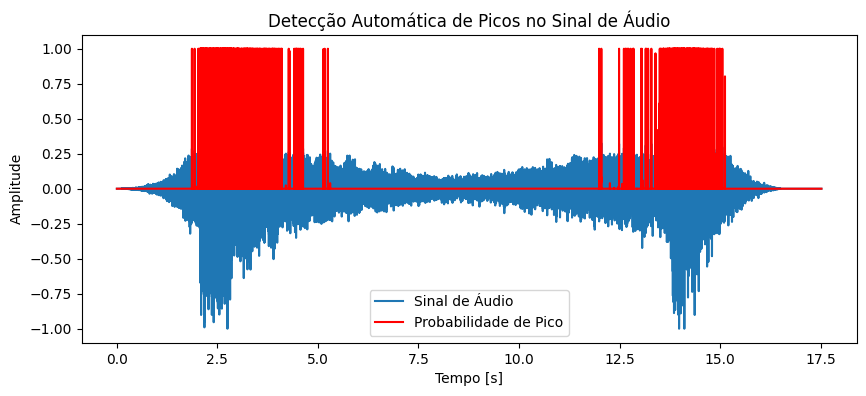

In [8]:
# janela 100 epoch 400
detected_peaks = []
with torch.no_grad():
    for i in range(len(normalized_signal) - windows_size):
        window = normalized_signal[i:i + windows_size]
        window_tensor = torch.tensor(window, dtype=torch.float32).unsqueeze(0)
        peak_prob = model(window_tensor).item()
        detected_peaks.append(peak_prob)

# Plotar os picos detectados
detected_peaks = np.array(detected_peaks)
plt.figure(figsize=(10, 4))
plt.plot(time_axis[:len(detected_peaks)], normalized_signal[:len(detected_peaks)], label='Sinal de Áudio')
plt.plot(time_axis[:len(detected_peaks)], detected_peaks, color='red', label='Probabilidade de Pico')
plt.title('Detecção Automática de Picos no Sinal de Áudio')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

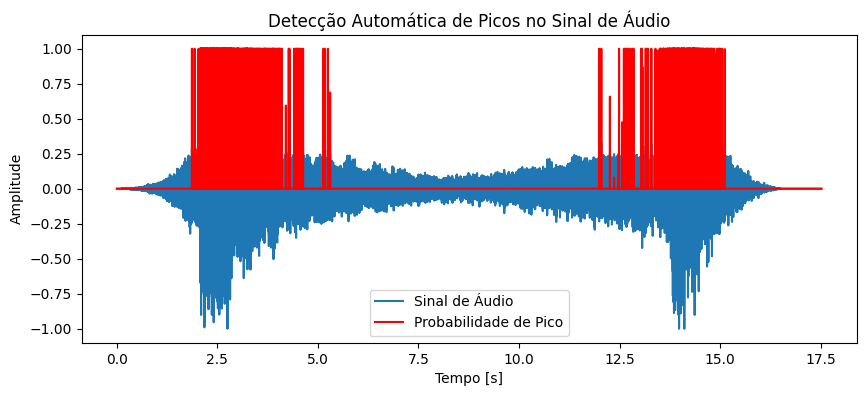

In [10]:
# janela 50 epoch 200
detected_peaks = []
with torch.no_grad():
    for i in range(len(normalized_signal) - windows_size):
        window = normalized_signal[i:i + windows_size]
        window_tensor = torch.tensor(window, dtype=torch.float32).unsqueeze(0)
        peak_prob = model(window_tensor).item()
        detected_peaks.append(peak_prob)

# Plotar os picos detectados
detected_peaks = np.array(detected_peaks)
plt.figure(figsize=(10, 4))
plt.plot(time_axis[:len(detected_peaks)], normalized_signal[:len(detected_peaks)], label='Sinal de Áudio')
plt.plot(time_axis[:len(detected_peaks)], detected_peaks, color='red', label='Probabilidade de Pico')
plt.title('Detecção Automática de Picos no Sinal de Áudio')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [14]:
print(max(detected_peaks))


1.0
